# Установка и импорт необходимых библиотек

In [1]:
!pip install --proxy 10.0.0.1:3128 nltk gensim pandas pymorphy2 emoji numpy

Using legacy 'setup.py install' for docopt, since package 'wheel' is not installed.
    Running setup.py install for docopt: started
    Running setup.py install for docopt: finished with status 'done'


You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [94]:
!pip install --proxy 10.0.0.1:3128 matplotlib

ERROR: Could not find a version that satisfies the requirement matplotlib (from versions: none)
ERROR: No matching distribution found for matplotlib
You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [128]:
import pandas as pd
import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from gensim.models import Word2Vec as wv
from gensim.models import KeyedVectors
import pymorphy2
from pymorphy2 import MorphAnalyzer
import emoji
import zipfile
import numpy as np
from pymongo import MongoClient
import json
from collections import Counter
import matplotlib.pyplot as plt
import datetime
import time

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [5]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [6]:
nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_ru.zip.


True

In [7]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

# Загрузка датасета из mongo db

In [9]:
def get_db_connection(db_server, db_name, collection_name):
    client = MongoClient(db_server, 27017)
    db = client[db_name]
    connection = db[collection_name]
    return connection

In [10]:
connector = get_db_connection('localhost', 'parcer', 'posts')

In [40]:
res = list(connector.find())

In [54]:
mongo_data = list()

In [55]:
for doc in res:
    mongo_data.append(doc['text'])

In [56]:
mongo_ds = pd.Series(mongo_data, copy=False, dtype=object)

In [57]:
mongo_ds

0         🌙Спокойной ночи, Барнаул!😴\n\nФото:  onetones
1     ⚠️ На Павловском тракте сегодня произошло ДТП....
2     ⛔️Ограничено движение для всех видов транспорт...
3     ⚠️Утро понедельника добрым не бывает. \n\nЕхал...
4     ⚠️ Дом на проспекте Ленина, 133 решили рассели...
                            ...                        
82    Как отдохнуть дешевле? 🤔⠀\n⠀⠀\nПодпишитесь на ...
83    ⚠️ Спасение у Четырёх братьев \n\nИ вновь спас...
84    🙏 Пост благодарности\n\n- Хочу выразить огромн...
85    🌿 Весна основательно пришла на заповедные бере...
86       ☀️Доброе утро, Барнаул! Сегодня днем +13...+15
Length: 87, dtype: object

In [137]:
posts_count = mongo_ds.count()

In [59]:
mongo_comments = list()

In [61]:
for doc in res:
    for comment in doc['comments']:
        mongo_comments.append(comment['text'])

In [63]:
comments_ds = pd.Series(mongo_comments, copy=False, dtype=object)

In [64]:
comments_ds

0                                                  Дубай?
1                           [id304160659|Боб], Барнаулай.
2                       Это Ковш??? Его хотят засыпать???
3                                  [id87386708|Елена], да
4       Какая красота😁\nИ еще хотят его засыпать, его ...
                              ...                        
1432         Это где это +13, +15  на каких югах Барнаула
1433                                                     
1434                                                     
1435              Доброе утро, Алтай! Хорошего дня всем!✌
1436                                                  🌸🌸🌸
Length: 1437, dtype: object

In [138]:
comments_count = comments_ds.count()

In [65]:
all_data = pd.concat([comments_ds, mongo_ds], ignore_index=True)

In [81]:
reserved_data = pd.concat([comments_ds, mongo_ds], ignore_index=True)

In [66]:
all_data

0                                                  Дубай?
1                           [id304160659|Боб], Барнаулай.
2                       Это Ковш??? Его хотят засыпать???
3                                  [id87386708|Елена], да
4       Какая красота😁\nИ еще хотят его засыпать, его ...
                              ...                        
1519    Как отдохнуть дешевле? 🤔⠀\n⠀⠀\nПодпишитесь на ...
1520    ⚠️ Спасение у Четырёх братьев \n\nИ вновь спас...
1521    🙏 Пост благодарности\n\n- Хочу выразить огромн...
1522    🌿 Весна основательно пришла на заповедные бере...
1523       ☀️Доброе утро, Барнаул! Сегодня днем +13...+15
Length: 1524, dtype: object

In [140]:
comments_avg = comments_count/posts_count

In [141]:
comments_rounded = round(comments_avg, 1)

In [142]:
comments_rounded 

16.5

# Предобработка сообщений социальной сети

In [67]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', str(doc))
    for c in str(doc):
      if emoji.is_emoji(c):
          i = doc.index(c)
          doc = doc[:i] + doc[i:]
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
        elif emoji.is_emoji(token):
            tokens.append(token)
    return tokens

In [68]:
all_data = all_data.apply(lemmatize)

In [69]:
all_data = all_data.dropna()

In [70]:
all_data

0                                                 [дубай]
1                                        [боб, барнаулай]
2                       [это, ковш, он, хотеть, засыпать]
3                                                 [елена]
4       [какой, красота😁, и, хотеть, засыпать, нужно, ...
                              ...                        
1519    [как, отдохнуть, дешёвый, 🤔⠀, ⠀⠀, подписаться,...
1520    [⚠️, спасение, четыре, брат, и, вновь, спасате...
1521    [🙏, пост, благодарность, хотеть, выразить, огр...
1522    [🌿, весна, основательно, прийти, заповедный, б...
1523             [☀️добрый, утро, барнаул, сегодня, день]
Length: 1524, dtype: object

# Статистика использования СГИ в сообщениях соц сети 

In [73]:
total = all_data.count()

In [74]:
total

1524

In [75]:
def split(s):
    return [char for char in s]


def check(comment):
    flag=0
    for item in comment:
        for c in split(item):
            if emoji.is_emoji(c):
                flag+=1
    if flag > 0:
        return(comment)
    return None 

In [76]:
all_data = all_data.apply(check)

In [77]:
all_data = all_data.dropna()

In [78]:
all_data

4       [какой, красота😁, и, хотеть, засыпать, нужно, ...
6       [антон, приложить, усилие, улучшение, кошка, д...
9       [перепутать, газ, тормозом😂, трезвый, ездить, ...
10      [владислав, ещё, выступать, начать, судить, фо...
13      [жек, красавчик, борцуха, 😂☝️, когда, суета, н...
                              ...                        
1519    [как, отдохнуть, дешёвый, 🤔⠀, ⠀⠀, подписаться,...
1520    [⚠️, спасение, четыре, брат, и, вновь, спасате...
1521    [🙏, пост, благодарность, хотеть, выразить, огр...
1522    [🌿, весна, основательно, прийти, заповедный, б...
1523             [☀️добрый, утро, барнаул, сегодня, день]
Length: 332, dtype: object

In [79]:
all_data.count()

332

In [80]:
all_data.count()/total

0.2178477690288714

# График по количеству публикаций в день 

In [83]:
res[0]

{'_id': ObjectId('64268222eddd3948046724a5'),
 'public': 'https://vk.com/barneos22',
 'id': 7339263,
 'date': '28/03/2023',
 'text': '🌙Спокойной ночи, Барнаул!😴\n\nФото:  onetones',
 'comments': [{'user': 304160659, 'text': 'Дубай?'},
  {'user': 174754608, 'text': '[id304160659|Боб], Барнаулай.'},
  {'user': 87386708, 'text': 'Это Ковш??? Его хотят засыпать???'},
  {'user': 38382358, 'text': '[id87386708|Елена], да'},
  {'user': 398907352,
   'text': 'Какая красота😁\nИ еще хотят его засыпать, его нужно облагородить и дать людям возможность отдыхать, как было запланировано по проекту, набережная с стоянкой маломерных судов.'},
  {'user': 134867674,
   'text': '[id398907352|Владимир], а пока там дохлые кошки валяются. Отличное место для прогулок.'},
  {'user': 398907352,
   'text': '[id134867674|Антон], так приложить усилия для улучшения, а кошки дохлые, после зимы много где оттаят😉'},
  {'user': 486034143, 'text': 'Когда сделано фото ?'},
  {'user': 20826319,
   'text': 'да просто верну

In [87]:
date_counter = list()

In [113]:
for doc in res:
    date_stamp = int(datetime.datetime.strptime(doc['date'], "%d/%m/%Y").timestamp())
    date_counter.append(date_stamp)

In [114]:
cnt = Counter(date_counter)

In [116]:
cnt

Counter({1679950800: 30, 1680123600: 68, 1680037200: 76})

In [121]:
counter_dict = dict(cnt)

In [124]:
counter_dict 

{1679950800: 30, 1680123600: 68, 1680037200: 76}

In [122]:
sorted_dict = sorted(counter_dict)

In [123]:
plot_dict = {}

In [147]:
for k in sorted_dict:
    print(k)
    stmp_date = time.gmtime(k + 86400)
    readable = time.strftime("%d.%m.%Y", stmp_date)
    plot_dict[readable] = counter_dict[k]

1679950800
1680037200
1680123600


In [148]:
plot_dict

{'28.03.2023': 30, '29.03.2023': 76, '30.03.2023': 68}

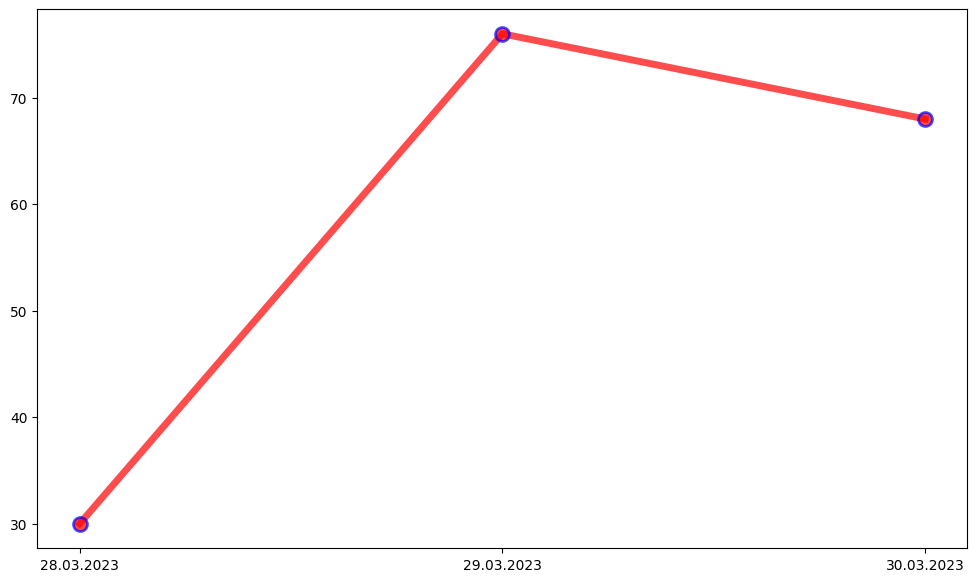

In [149]:
x = plot_dict.keys()
y = plot_dict.values()

plt.figure(figsize=(12, 7))
plt.plot(x, y, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)